In [220]:
# Estratégia utilizada (Resumo):
# 1 - Leitura e formatação(1) básica do DataFrame (Treino e teste (df e dft)) (transformação do target em binário, remoção de linhas duplicadas, e enumeração dos atributos)
# 2 - Análise das variáveis do DataFrame(df)
# 3 - Análise da distribuição do target(df['income']) 
# 4 - Análise de distribuição e correlação entre os atributos numéricos e o target
# 5 - Análise de distribuição e correlação entre os atributos categóricos e o target
# 6 - Formatação(2) do DataFrame (df e dft) (tratamento de valores faltantes (inserção com a moda da coluna), transformação dos atributos categóricos em numéricos (foi testado label encoder e one hot encoding. One hot encoding foi escolhido)
#    , remoção de colunas com baixa correlação com o target, e remoção de colunas duplicadas(education e education.num))
# 7 - Tratamento de Outliers com Robust Scaler
# 8 - Análise da importância das features restantes com o algoritmo ExtraTreesClassifier, e remoção das colunas com baixa importância abaixo de um valor arbitrario(threshold = 0.001)
# 9 - Gridsearch dos melhores parâmetros para o algoritmo KNN (foram testados grandes ranges de valores. Os melhores valores estão descritos na ultima linha do output da célula final)
# 10 - Treinamento do modelo com os melhores parâmetros encontrados
# 11 - Resultados do modelo com os dados de teste (dft)

In [221]:
# bibliotecas para manipulação de dados
import numpy as np
import pandas as pd

# bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

# utilizado para esconder alguns warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# bibliotecas utilizadas para o modelo KNN 
import sklearn
#from sklearn.preprocessing import LabelEncoder (comentado para não entrar em conflito com o one hot encoder)
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score

In [222]:
# 1 - Leitura e formatação(1) básica do DataFrame (Treino e teste (df e dft)) (transformação do target em binário, remoção de linhas duplicadas, e enumeração dos atributos)

df_raw = pd.read_csv(r"<FILEpath>") # mudar o path para o dataset
dft_raw = pd.read_csv(r"<FILEpath>", skiprows=1)

df_dropped = df_raw.drop_duplicates(keep='first')
dft_dropped = dft_raw.drop_duplicates(keep='first')

df = df_dropped.replace(' ?', np.nan,)
dft = dft_dropped.replace(' ?', np.nan)

df = df.replace({' <=50K': 0, ' >50K': 1})
dft = dft.replace({' <=50K.': 0, ' >50K.': 1})

In [223]:
new_columns = ['age',
 'workclass',
 'fnlwgt',
 'education',
 'education.num',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'native.country',
 'income']
df.columns = new_columns
dft.columns = new_columns

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32536 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32536 non-null  int64 
 1   workclass       30700 non-null  object
 2   fnlwgt          32536 non-null  int64 
 3   education       32536 non-null  object
 4   education.num   32536 non-null  int64 
 5   marital.status  32536 non-null  object
 6   occupation      30693 non-null  object
 7   relationship    32536 non-null  object
 8   race            32536 non-null  object
 9   sex             32536 non-null  object
 10  capital.gain    32536 non-null  int64 
 11  capital.loss    32536 non-null  int64 
 12  hours.per.week  32536 non-null  int64 
 13  native.country  31954 non-null  object
 14  income          32536 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 4.0+ MB


In [225]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     582
income               0
dtype: int64

In [226]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income
count,32536.000000,3.253600e+04,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000
mean,38.585536,1.897843e+05,10.081725,1078.410069,87.370912,40.440343,0.240933
std,13.638193,1.055563e+05,2.571622,7388.068465,403.107737,12.347079,0.427656
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.369932e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [227]:
# 2 - Análise das variáveis do DataFrame(df)
df.head(20)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
5,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,0
6,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
7,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
8,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,1
9,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,1


In [228]:
dft.head(20)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
3,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,0
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
5,29,NaN,227026,HS-grad,9,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States,0
6,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,1
7,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,0
8,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,0
9,65,Private,184454,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,6418,0,40,United-States,1


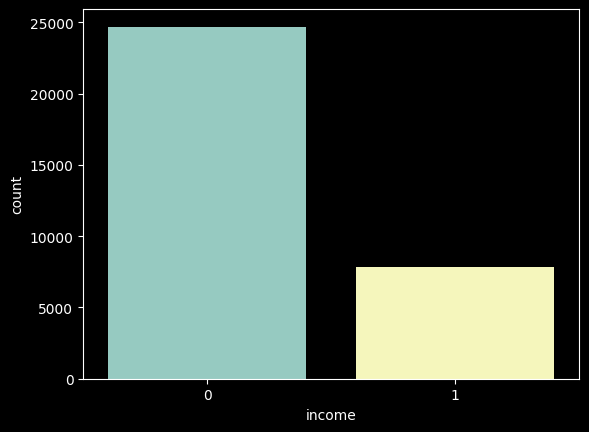

In [229]:
# 3 - Análise da distribuição do target(df['income'])
sns.countplot(x='income', data=df)
plt.show()


In [230]:
numerical_cols = df.select_dtypes(include=['int64'])
numerical_cols = numerical_cols.drop(['income'], axis=1)
print (numerical_cols)

       age  fnlwgt  education.num  capital.gain  capital.loss  hours.per.week
0       50   83311             13             0             0              13
1       38  215646              9             0             0              40
2       53  234721              7             0             0              40
3       28  338409             13             0             0              40
4       37  284582             14             0             0              40
...    ...     ...            ...           ...           ...             ...
32555   27  257302             12             0             0              38
32556   40  154374              9             0             0              40
32557   58  151910              9             0             0              40
32558   22  201490              9             0             0              20
32559   52  287927              9         15024             0              40

[32536 rows x 6 columns]


In [231]:
nominal_columns = df.select_dtypes(include=['object'])
print (nominal_columns)

               workclass    education       marital.status  \
0       Self-emp-not-inc    Bachelors   Married-civ-spouse   
1                Private      HS-grad             Divorced   
2                Private         11th   Married-civ-spouse   
3                Private    Bachelors   Married-civ-spouse   
4                Private      Masters   Married-civ-spouse   
...                  ...          ...                  ...   
32555            Private   Assoc-acdm   Married-civ-spouse   
32556            Private      HS-grad   Married-civ-spouse   
32557            Private      HS-grad              Widowed   
32558            Private      HS-grad        Never-married   
32559       Self-emp-inc      HS-grad   Married-civ-spouse   

               occupation    relationship    race      sex  native.country  
0         Exec-managerial         Husband   White     Male   United-States  
1       Handlers-cleaners   Not-in-family   White     Male   United-States  
2       Handlers-cleaner

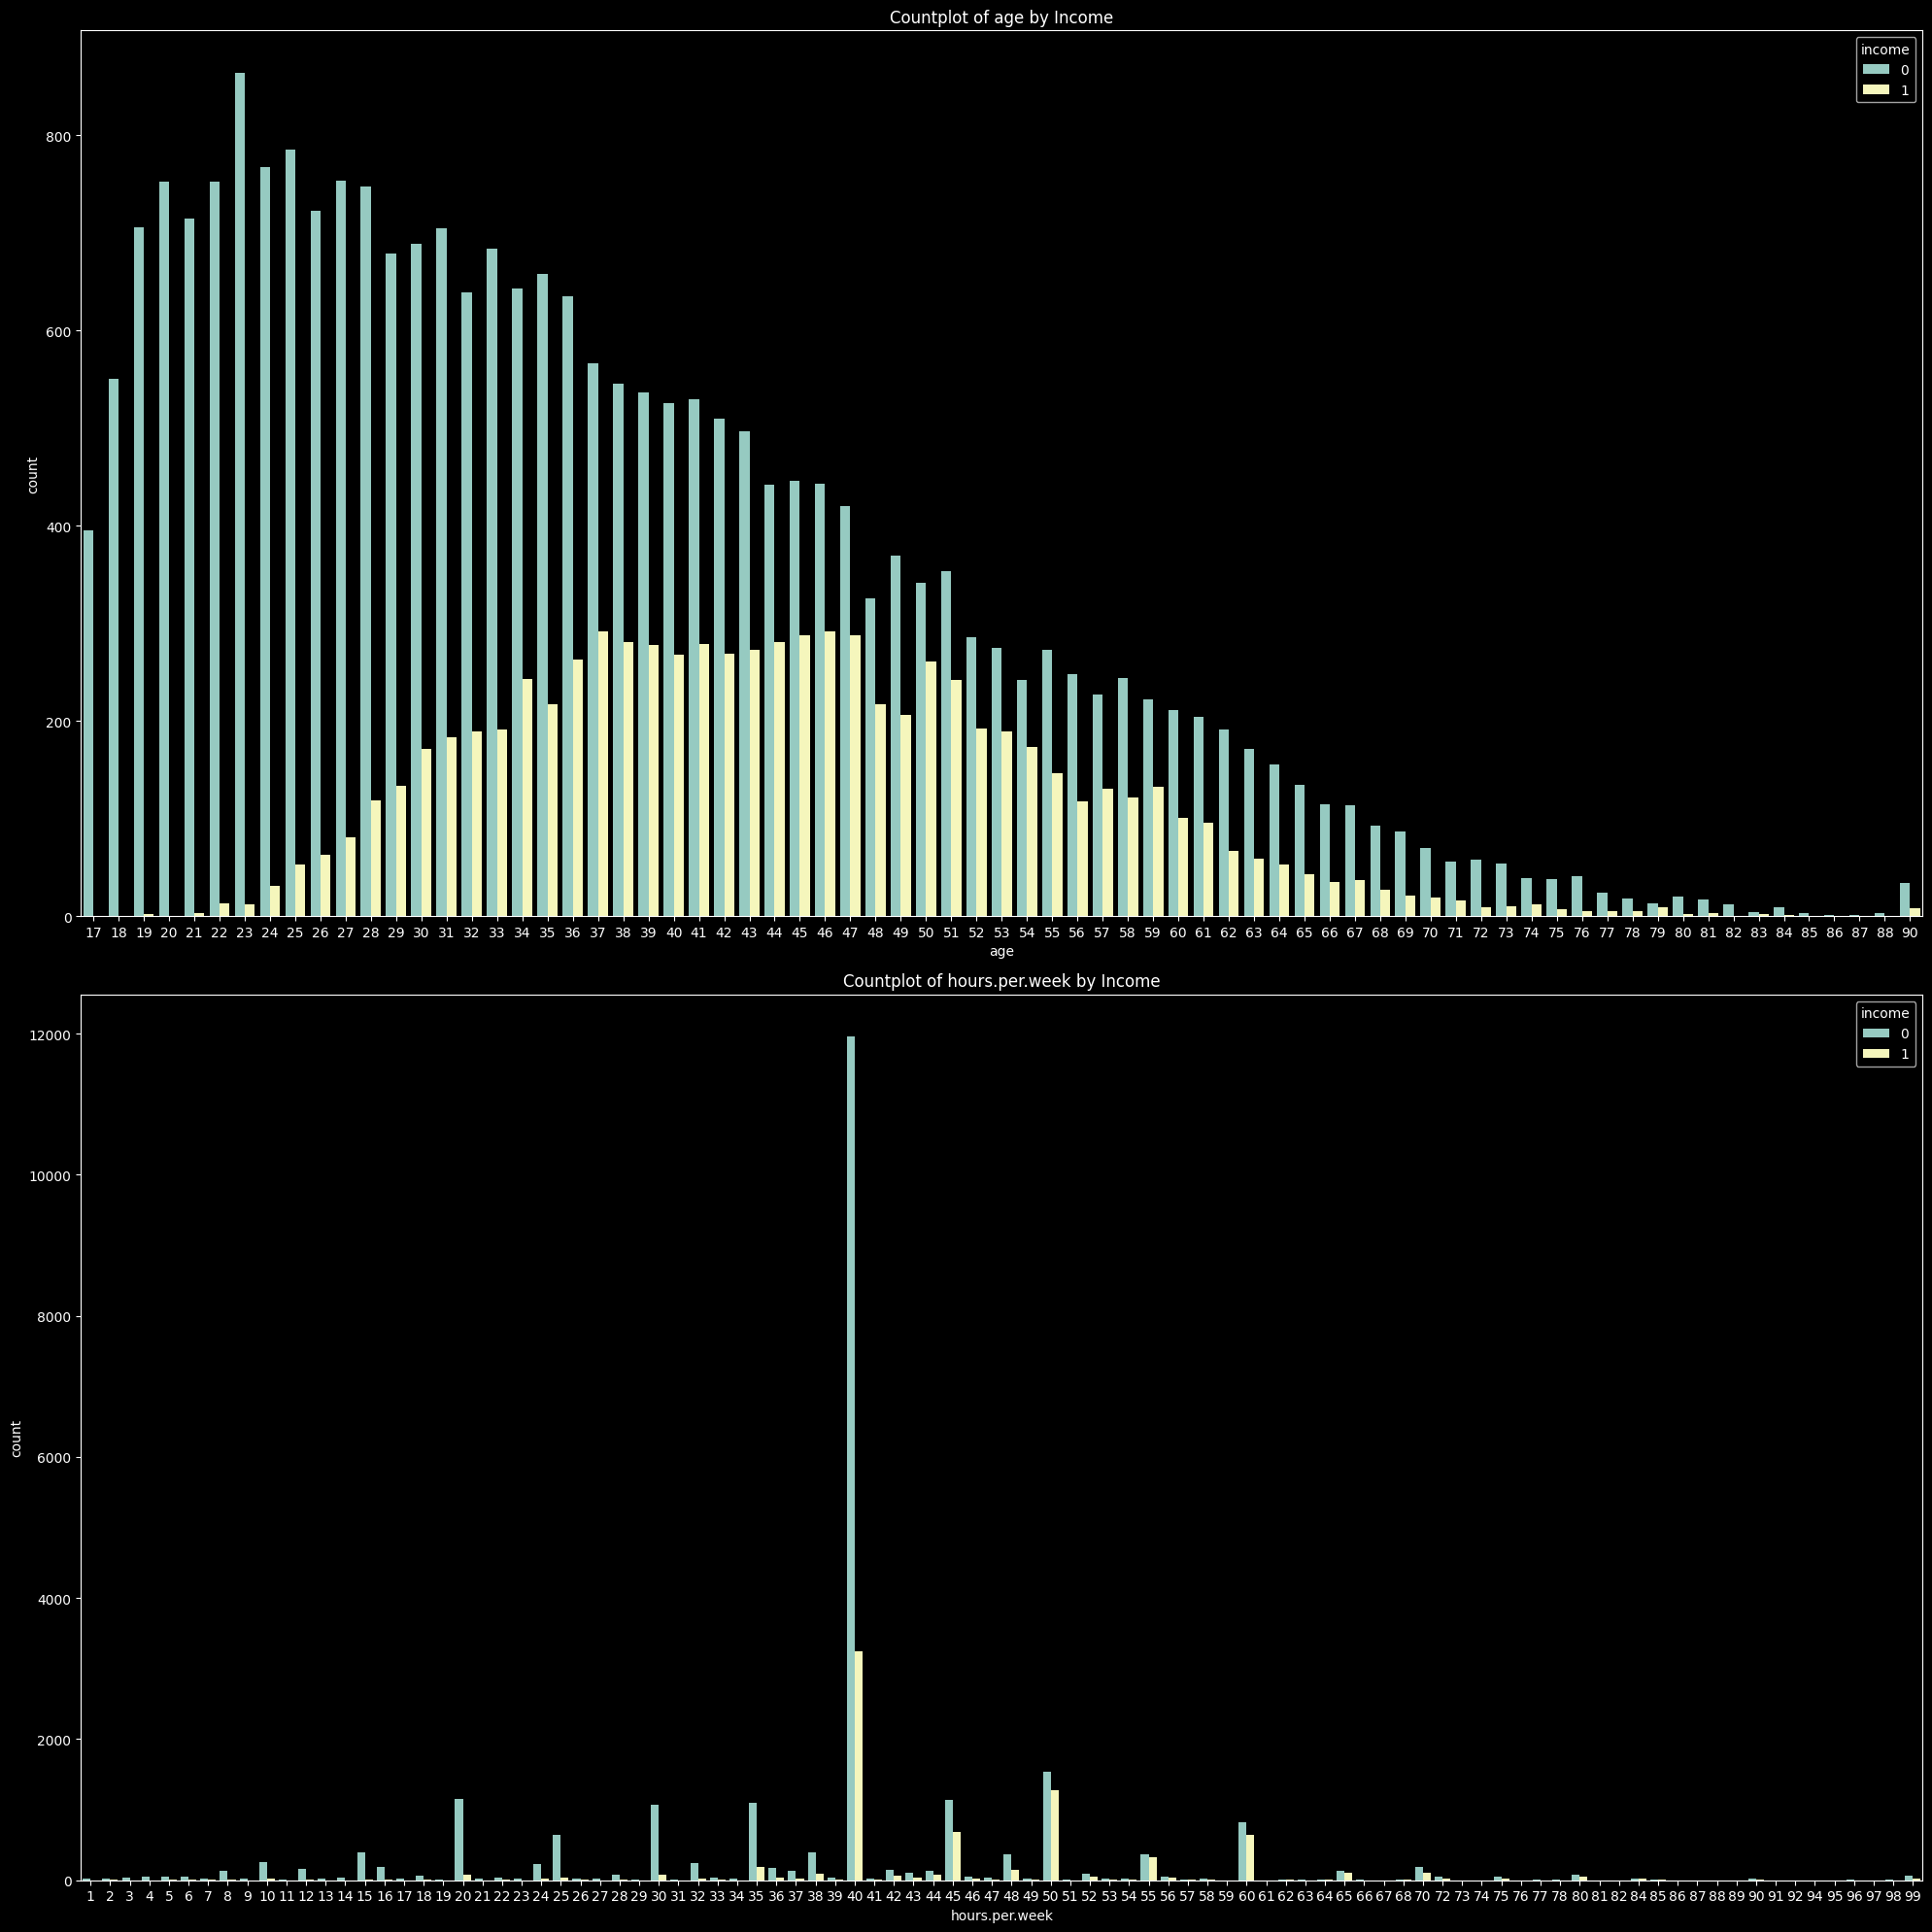

In [232]:
# 4 - Análise de distribuição e correlação entre os atributos numéricos e o target

income = df[['income']]

numerical_cols_2 = numerical_cols.drop(columns=['fnlwgt', 'education.num', 'capital.gain','capital.loss'])
# fnlwgt - foi removido pois não tem sentido estatístico 
# education ja foi analisado nos atributos nominais
# capital gain e loss foram removidos pois tem muitos valores nulos

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
for i, col in enumerate(numerical_cols_2.columns):
    sns.countplot(x=col, hue='income', data=df, ax=axes[i])
    axes[i].set_title(f'Countplot of {col} by Income')

plt.tight_layout()

plt.show()

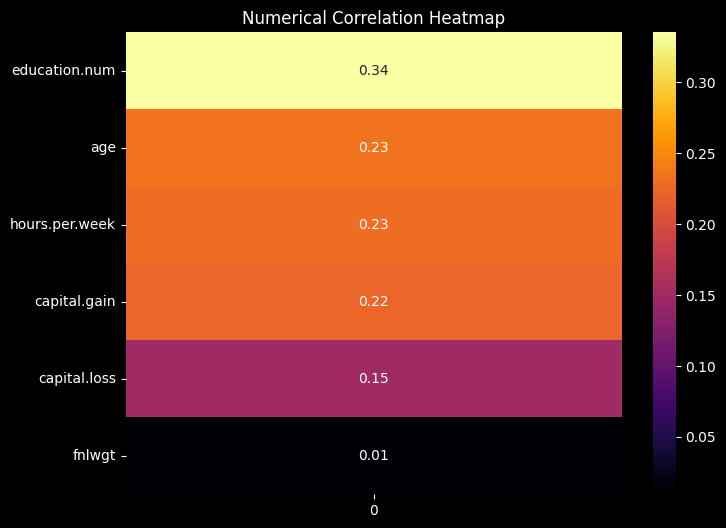

In [233]:
correlation_matrix = numerical_cols.corrwith(income['income']).abs().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='inferno', fmt='.2f')
plt.title('Numerical Correlation Heatmap')
plt.show()

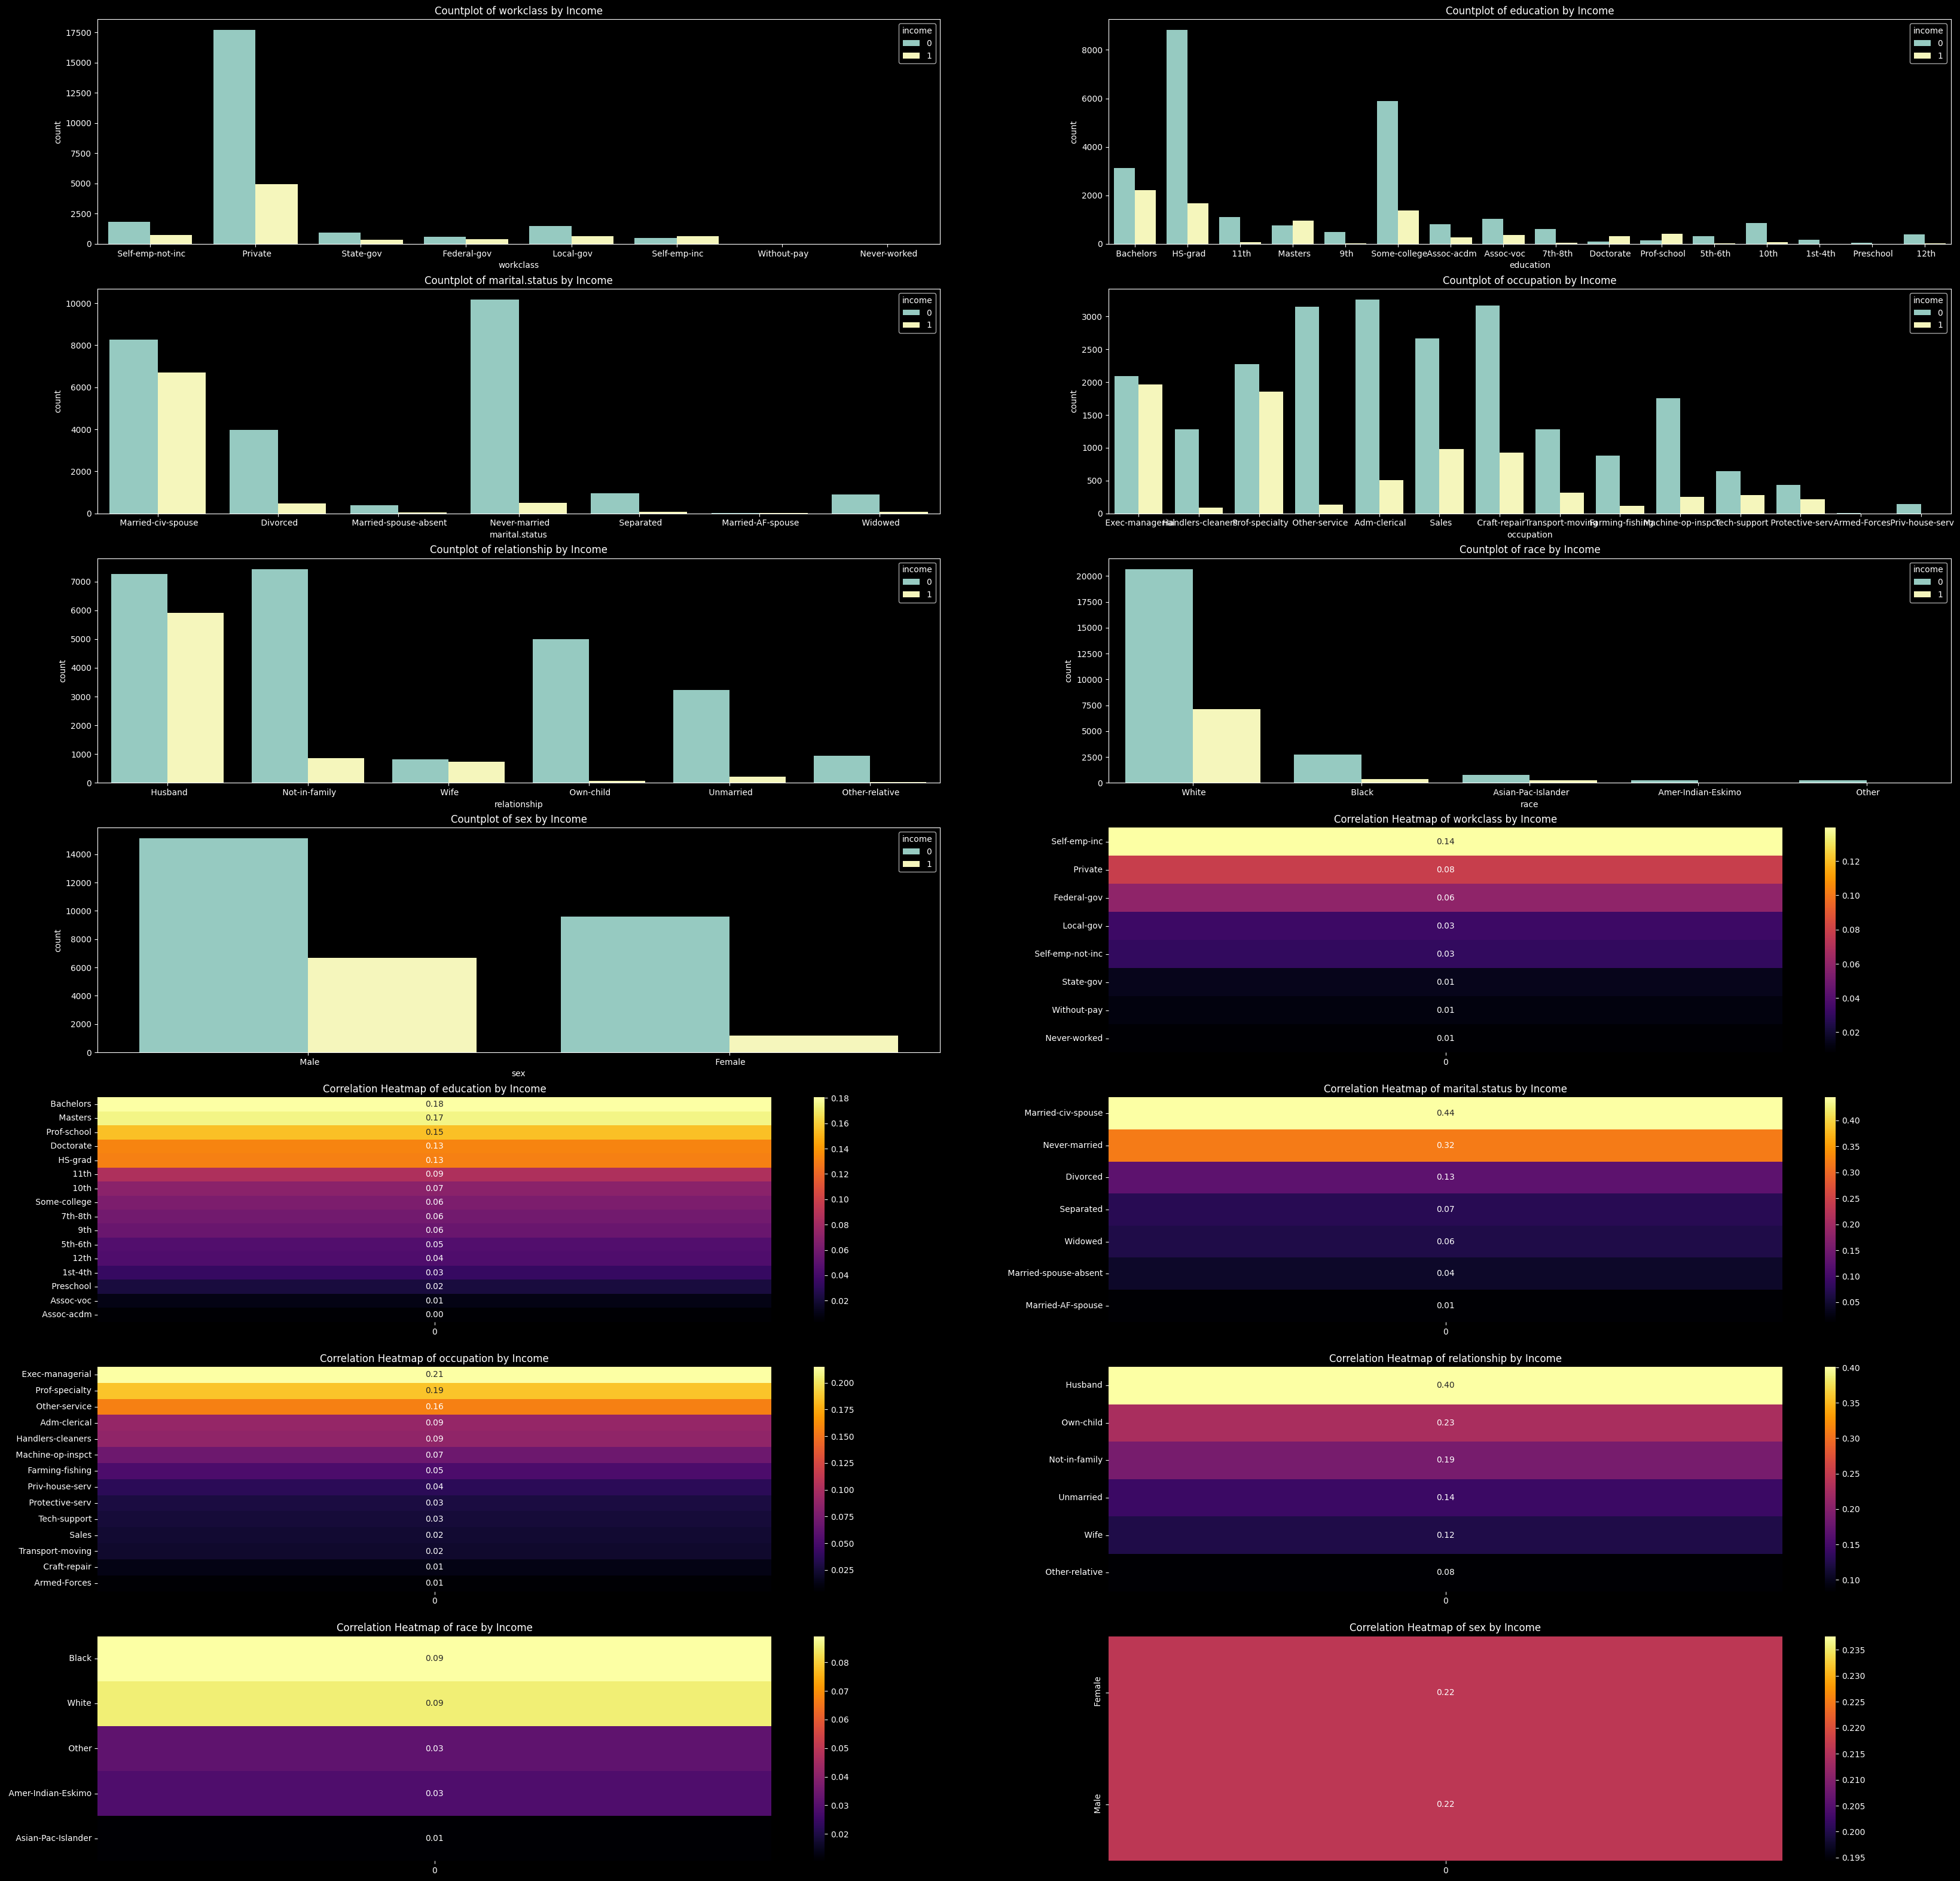

In [234]:
# 5 - Análise de distribuição e correlação entre os atributos categóricos e o target

fig, axs = plt.subplots(ncols=2, nrows=7, figsize=(40, 40))
axs = axs.flatten()

for i, col in enumerate(['workclass','education', 'marital.status','occupation','relationship','race','sex']):
    sns.countplot(x=col, hue='income', data=df, ax=axs[i])
    axs[i].set_title(f'Countplot of {col} by Income')

    corr = pd.get_dummies(nominal_columns[col]).corrwith(income['income']).abs().sort_values(ascending=False)

    sns.heatmap(corr.to_frame(), annot=True, cmap='inferno', fmt='.2f', ax=axs[i + 7])
    axs[i+7].set_title(f'Correlation Heatmap of {col} by Income')


In [235]:
# 6 - Formatação(2) do DataFrame (df e dft)

df_full = df.fillna(df[col].mode()[0])
dft_full = dft.fillna(dft[col].mode()[0])
df_full.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [236]:
dft_full.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [237]:
df_full = df_full.drop(columns=['fnlwgt','education'])
dft_full = dft_full.drop(columns=['fnlwgt','education'])

# One hot encoding
categorical_columns = df_full.select_dtypes(include=['object']).columns.tolist()
df_le = pd.get_dummies(df_full, columns=categorical_columns, drop_first=True)
dft_le = pd.get_dummies(dft_full, columns=categorical_columns, drop_first=True)
print(df_le)

       age  education.num  capital.gain  capital.loss  hours.per.week  income  \
0       50             13             0             0              13       0   
1       38              9             0             0              40       0   
2       53              7             0             0              40       0   
3       28             13             0             0              40       0   
4       37             14             0             0              40       0   
...    ...            ...           ...           ...             ...     ...   
32555   27             12             0             0              38       0   
32556   40              9             0             0              40       1   
32557   58              9             0             0              40       0   
32558   22              9             0             0              20       0   
32559   52              9         15024             0              40       1   

       workclass_ Local-gov

In [238]:
#Label encoder (não utilizado, mas testado)
#def label_encoder(df, atributos_cat):
#    df_le = df.copy()
#    le = LabelEncoder()
#    df_le[atributos_cat] = df_le[atributos_cat].apply(lambda series: pd.Series(le.fit_transform(series[series.notnull()]), index=series[series.notnull()].index))
#    
#    return df_le

In [239]:
#df_le = label_encoder(df_full, nominal_columns.columns)
#df_le.head(10)

In [240]:
#dft_le = label_encoder(dft_full, nominal_columns.columns)
#dft_le.head(10)

In [241]:
X_train = df_le.drop(columns=['income'])
y_train = df_le['income']

X_test = dft_le.drop(columns=['income'])
y_test = dft_le['income']

In [242]:
#Correção de um problema em que o número de colunas do X_train e X_test não eram iguais(fonte do problema desconhecida)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
X_test.head(10)

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass_ Local-gov,workclass_ Male,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,native.country_ Portugal,native.country_ Puerto-Rico,native.country_ Scotland,native.country_ South,native.country_ Taiwan,native.country_ Thailand,native.country_ Trinadad&Tobago,native.country_ United-States,native.country_ Vietnam,native.country_ Yugoslavia
0,38,9,0,0,50,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,28,12,0,0,40,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,44,10,7688,0,40,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,18,10,0,0,30,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,34,6,0,0,30,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
5,29,9,0,0,40,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
6,63,15,3103,0,32,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
7,24,10,0,0,40,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
8,55,4,0,0,10,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
9,65,9,6418,0,40,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False


In [243]:
# 7 - Tratamento de Outliers com Robust Scaler
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)

In [244]:
# 8 - Análise da importância das features restantes com o algoritmo ExtraTreesClassifier, e remoção das colunas com baixa importância abaixo de um valor arbitrario(threshold = 0.001)
selection = ExtraTreesClassifier()

selection.fit(X_train, y_train)
importances = selection.feature_importances_

In [245]:
print (importances)
impotances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print (impotances)

[2.21673223e-01 1.24800664e-01 8.57990060e-02 2.85662534e-02
 1.23966494e-01 5.56683119e-03 1.54055309e-03 4.87408366e-06
 9.44604180e-03 7.57503722e-03 8.35555622e-03 4.92489209e-03
 1.50798348e-04 4.42921904e-04 1.00766698e-01 1.42848525e-03
 3.69629306e-02 2.96221268e-03 2.50125659e-03 3.88425363e-05
 6.66082783e-03 2.91205235e-02 5.33637390e-03 4.61944264e-03
 5.32379493e-03 1.96462339e-03 1.16093302e-02 3.17254893e-04
 2.53935248e-02 2.78427891e-03 5.96652774e-03 4.68799593e-03
 4.69829690e-03 1.83110443e-02 2.95711531e-03 1.64540897e-02
 9.12389706e-03 9.63411015e-03 3.08362249e-03 4.93109788e-03
 1.06793795e-03 6.00456824e-03 2.21849206e-02 1.41362627e-03
 5.74217106e-04 4.29202943e-04 9.23730021e-04 3.00389463e-04
 2.00919108e-04 3.78413352e-04 1.14427453e-03 4.33711679e-04
 1.42591812e-03 4.55810050e-04 2.19672133e-04 3.05980328e-04
 5.34626305e-07 1.29157969e-05 1.97651638e-04 2.63436868e-04
 8.84429700e-04 6.46172128e-04 2.47787874e-04 1.09779221e-03
 4.89549678e-04 7.867535

<Axes: >

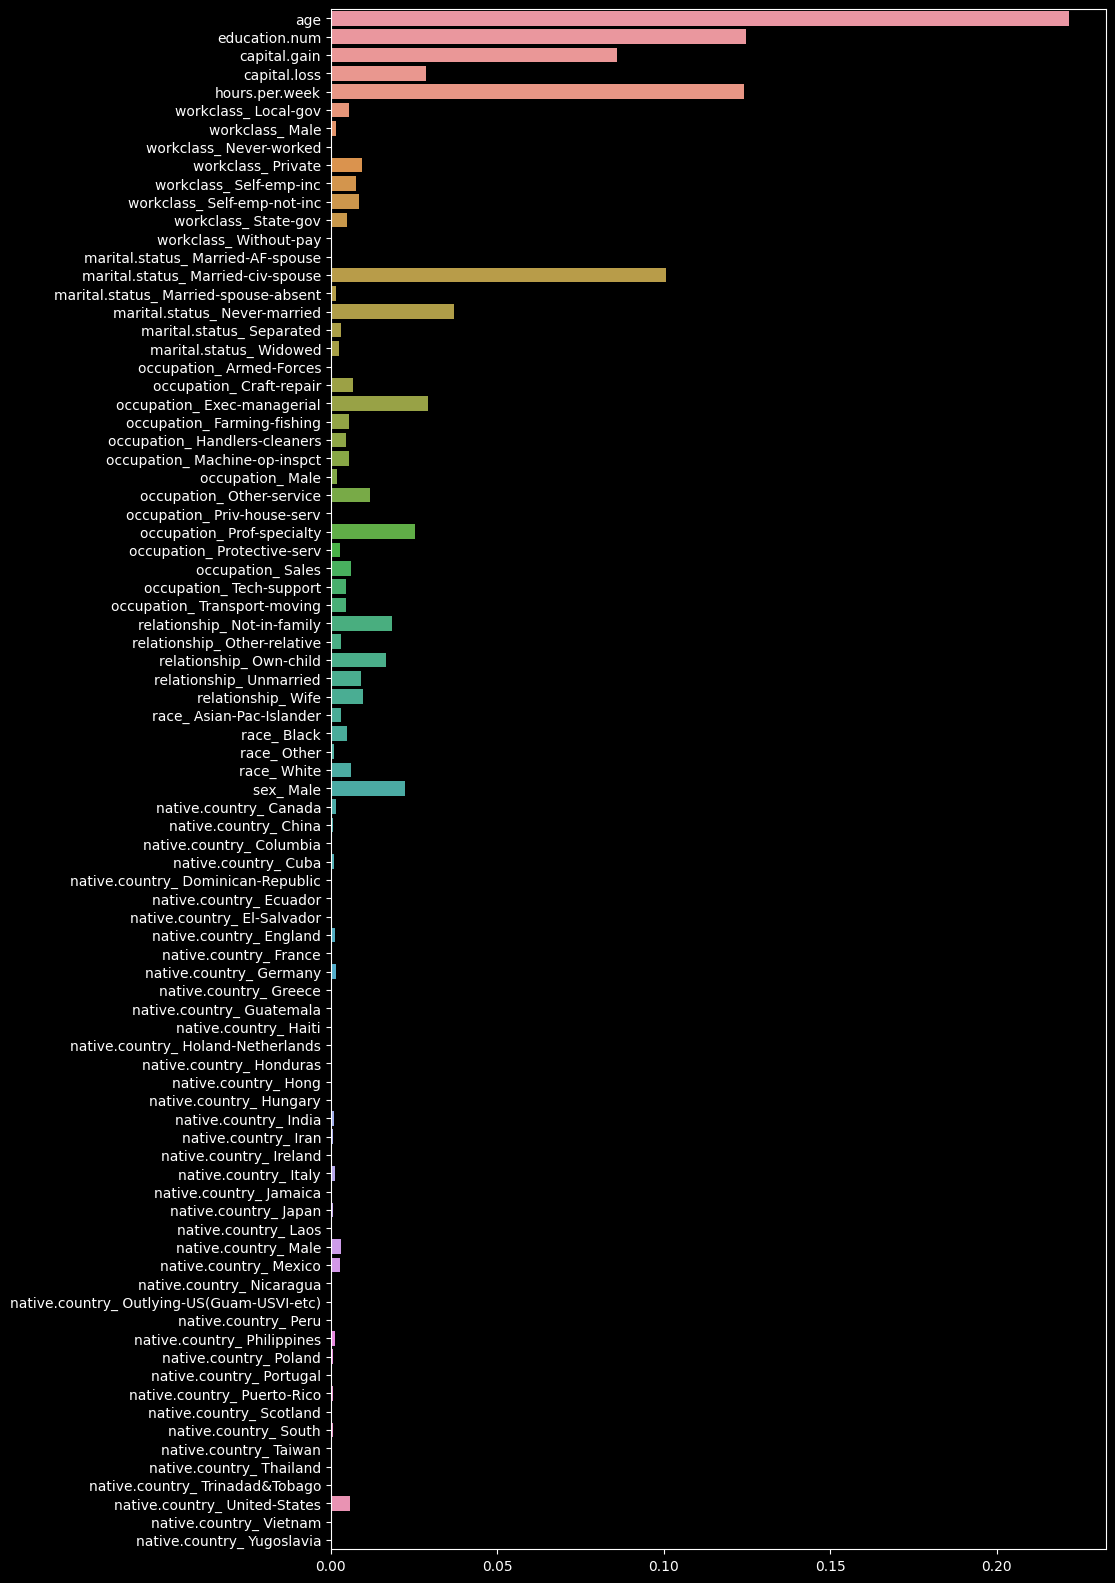

In [246]:
plt.figure(figsize=(10, 20))
sns.barplot(x=importances, y=X_train.columns)

In [247]:
threshold = 0.003
feature_mask = importances > threshold
X_train = X_train.loc[:, feature_mask]
X_train.head(10)

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,relationship_ Not-in-family,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ White,sex_ Male,native.country_ Male,native.country_ United-States
0,50,13,0,0,13,False,False,False,True,False,...,False,False,False,False,False,False,True,True,False,True
1,38,9,0,0,40,False,True,False,False,False,...,True,False,False,False,False,False,True,True,False,True
2,53,7,0,0,40,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,True
3,28,13,0,0,40,False,True,False,False,False,...,False,False,False,True,False,True,False,False,False,False
4,37,14,0,0,40,False,True,False,False,False,...,False,False,False,True,False,False,True,False,False,True
5,49,5,0,0,16,False,True,False,False,False,...,True,False,False,False,False,True,False,False,False,False
6,52,9,0,0,45,False,False,False,True,False,...,False,False,False,False,False,False,True,True,False,True
7,31,14,14084,0,50,False,True,False,False,False,...,True,False,False,False,False,False,True,False,False,True
8,42,13,5178,0,40,False,True,False,False,False,...,False,False,False,False,False,False,True,True,False,True
9,37,10,0,0,80,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,True


In [248]:
feature_mask.tolist()
X_test = X_test.loc[:, feature_mask]
X_test.head(10)

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,relationship_ Not-in-family,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ White,sex_ Male,native.country_ Male,native.country_ United-States
0,38,9,0,0,50,False,True,False,False,False,...,False,False,False,False,False,False,True,True,False,True
1,28,12,0,0,40,True,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
2,44,10,7688,0,40,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,True
3,18,10,0,0,30,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,True
4,34,6,0,0,30,False,True,False,False,False,...,True,False,False,False,False,False,True,True,False,True
5,29,9,0,0,40,False,False,False,False,False,...,False,False,True,False,False,True,False,True,False,True
6,63,15,3103,0,32,False,False,False,True,False,...,False,False,False,False,False,False,True,True,False,True
7,24,10,0,0,40,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True
8,55,4,0,0,10,False,True,False,False,False,...,False,False,False,False,False,False,True,True,False,True
9,65,9,6418,0,40,False,True,False,False,False,...,False,False,False,False,False,False,True,True,False,True


In [249]:
# 9 - Gridsearch dos melhores parâmetros para o algoritmo KNN (foram testados grandes ranges de valores. Os melhores valores estão descritos na ultima linha do output da célula final)
# 10 - Treinamento do modelo com os melhores parâmetros encontrados
# 11 - Resultados do modelo com os dados de teste (dft)

param_grid = {
    'n_neighbors': [49], #foi utilizado list(range(5, 50))
    'weights': ['uniform', 'distance'], #foi utilizado ['uniform', 'distance']
    'leaf_size': [5], #foi utilizado list(range(5, 35))
    'p':[1] #foi utilizado [1, 2]   
}

knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(
    knn_classifier,
    param_grid,
    cv=10,      
    n_jobs=-1,  
    verbose=1   
)

grid_search.fit(X_train_scaled, y_train)

best_knn_classifier = grid_search.best_estimator_

# Resultados do modelo com os dados de teste (dft)
accuracy = best_knn_classifier.score(X_test_scaled, y_test)
precision = precision_score(y_test, best_knn_classifier.predict(X_test_scaled))
recall = recall_score(y_test, best_knn_classifier.predict(X_test_scaled))
f1 = f1_score(y_test, best_knn_classifier.predict(X_test_scaled))
confusion_matrix = confusion_matrix(y_test, best_knn_classifier.predict(X_test_scaled))
print(f'Best Accuracy: {accuracy:.7f}\n Best Precision: {precision:.7f}\n Best Recall: {recall:.7f}\n Best F1-Score: {f1:.7f}\n Confusion Matrix:\n {confusion_matrix}')
print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Extra_Trees threshold: {threshold}')

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Best Accuracy: 0.8648848
 Best Precision: 0.7438555
 Best Recall: 0.6531461
 Best F1-Score: 0.6955559
 Confusion Matrix:
 [[11564   865]
 [ 1334  2512]]
Best Hyperparameters: {'leaf_size': 5, 'n_neighbors': 49, 'p': 1, 'weights': 'uniform'}
Extra_Trees threshold: 0.003
